In [ ]:
import os
import cv2
import scipy
import tempfile
import numpy as np
import tensorflow as tf
from subprocess import call
from scipy.io import wavfile
from tqdm import tqdm

#from psbody.mesh import Mesh
#from utils.audio_handler import  AudioHandler
#from utils.rendering import render_mesh_helper

def process_audio(ds_path, audio, sample_rate):
    config = {}
    config['deepspeech_graph_fname'] = ds_path
    config['audio_feature_type'] = 'deepspeech'
    config['num_audio_features'] = 29

    config['audio_window_size'] = 16
    config['audio_window_stride'] = 1

    tmp_audio = {'subj': {'seq': {'audio': audio, 'sample_rate': sample_rate}}}
    audio_handler = AudioHandler(config)
    return audio_handler.process(tmp_audio)['subj']['seq']['audio']

In [ ]:
'''
Max-Planck-Gesellschaft zur Foerderung der Wissenschaften e.V. (MPG) is holder of all proprietary rights on this
computer program.

You can only use this computer program if you have closed a license agreement with MPG or you get the right to use
the computer program from someone who is authorized to grant you that right.

Any use of the computer program without a valid license is prohibited and liable to prosecution.

Copyright 2019 Max-Planck-Gesellschaft zur Foerderung der Wissenschaften e.V. (MPG). acting on behalf of its
Max Planck Institute for Intelligent Systems and the Max Planck Institute for Biological Cybernetics.
All rights reserved.

More information about VOCA is available at http://voca.is.tue.mpg.de.
For comments or questions, please email us at voca@tue.mpg.de
'''

import re
import copy
import resampy
import numpy as np
import tensorflow as tf
import tensorflow.compat.v1 as v1
#from python_speech_features import mfcc


import librosa


def interpolate_features(features, input_rate, output_rate, output_len=None):
    num_features = features.shape[1]
    input_len = features.shape[0]
    seq_len = input_len / float(input_rate)
    if output_len is None:
        output_len = int(seq_len * output_rate)
    input_timestamps = np.arange(input_len) / float(input_rate)
    output_timestamps = np.arange(output_len) / float(output_rate)
    output_features = np.zeros((output_len, num_features))
    for feat in range(num_features):
        output_features[:, feat] = np.interp(output_timestamps,
                                             input_timestamps,
                                             features[:, feat])
    return output_features

class AudioHandler:
    def __init__(self, config):
        self.config = config
        self.audio_feature_type = config['audio_feature_type']
        self.num_audio_features = config['num_audio_features']
        self.audio_window_size = config['audio_window_size']
        self.audio_window_stride = config['audio_window_stride']

    def process(self, audio):
        if self.audio_feature_type.lower() == "none":
            return None
        elif self.audio_feature_type.lower() == 'deepspeech':
            return self.convert_to_deepspeech(audio)
        else:
            raise NotImplementedError("Audio features not supported")

    def convert_to_deepspeech(self, audio):
        def audioToInputVector(audio, fs, numcep, numcontext):
            # Get mfcc coefficients
            #features = mfcc(audio, samplerate=fs, numcep=numcep)
            features = librosa.feature.mfcc(y = audio, sr = fs, n_mfcc=numcep)
            #print(features.shape)
            # We only keep every second feature (BiRNN stride = 2)
            
            #features = features[::2]

            # One stride per time step in the input
            num_strides = len(features)
            # Add empty initial and final contexts
            empty_context = np.zeros((numcontext, numcep), dtype=features.dtype)
            features = np.concatenate((empty_context, features.T, empty_context))

            # Create a view into the array with overlapping strides of size
            # numcontext (past) + 1 (present) + numcontext (future)
            window_size = 2 * numcontext + 1
            train_inputs = np.lib.stride_tricks.as_strided(
                features,
                (num_strides, window_size, numcep),
                (features.strides[0], features.strides[0], features.strides[1]),
                writeable=False)

            # Flatten the second and third dimensions
            train_inputs = np.reshape(train_inputs, [num_strides, -1])

            train_inputs = np.copy(train_inputs)
            train_inputs = (train_inputs - np.mean(train_inputs)) / np.std(train_inputs)

            # Return results
            return train_inputs

        if type(audio) == dict:
            pass
        else:
            raise ValueError('Wrong type for audio')

        # Load graph and place_holders
        with v1.gfile.GFile(self.config['deepspeech_graph_fname'], "rb") as f:
            graph_def = v1.GraphDef()
            graph_def.ParseFromString(f.read())
        
        graph = v1.get_default_graph()
        v1.import_graph_def(graph_def, name="deepspeech")
        input_tensor = graph.get_tensor_by_name('input_node:0')
        seq_length = graph.get_tensor_by_name('input_lengths:0')
        layer_6 = graph.get_tensor_by_name('logits:0')
        
        
       
        n_input = 26
        n_context = 9

        processed_audio = copy.deepcopy(audio)
        with v1.Session(graph=graph) as sess:
            for subj in audio.keys():
                for seq in audio[subj].keys():
                    #print('process audio: %s - %s' % (subj, seq))

                    audio_sample = audio[subj][seq]['audio']
                    sample_rate = audio[subj][seq]['sample_rate']
                    resampled_audio = resampy.resample(audio_sample.astype(float), sample_rate, 16000)
                    input_vector = audioToInputVector(resampled_audio, 16000, n_input, n_context)

                    network_output = sess.run(layer_6, feed_dict={input_tensor: input_vector[np.newaxis, ...],
                                                                  seq_length: [input_vector.shape[0]]})
                    # Resample network output from 50 fps to 60 fps
                    audio_len_s = float(audio_sample.shape[0]) / sample_rate
                    num_frames = int(round(audio_len_s * 25))
                    network_output = interpolate_features(network_output[:, 0], 50, 25,
                                                          output_len=num_frames)

                    # Make windows
                    zero_pad = np.zeros((int(self.audio_window_size / 2), network_output.shape[1]))
                    network_output = np.concatenate((zero_pad, network_output, zero_pad), axis=0)
                    windows = []
                    for window_index in range(0, network_output.shape[0] - self.audio_window_size, self.audio_window_stride):
                        windows.append(network_output[window_index:window_index + self.audio_window_size])

                    processed_audio[subj][seq]['audio'] = np.array(windows)
        return processed_audio
    


In [ ]:
# -*- coding: utf-8 -*-
# Soohwan Kim, Seyoung Bae, Cheolhwang Won.
# @ArXiv : KoSpeech: Open-Source Toolkit for End-to-End Korean Speech Recognition
# This source code is licensed under the Apache 2.0 License license found in the
# LICENSE file in the root directory of this source tree.

import torch
import torch.nn as nn
from typing import Tuple, Optional, Any
from torch import Tensor, BoolTensor


class MaskConv(nn.Module):
    """
    Masking Convolutional Neural Network

    Adds padding to the output of the module based on the given lengths.
    This is to ensure that the results of the model do not change when batch sizes change during inference.
    Input needs to be in the shape of (batch_size, channel, hidden_dim, seq_len)

    Refer to https://github.com/SeanNaren/deepspeech.pytorch/blob/master/model.py
    Copyright (c) 2017 Sean Naren
    MIT License

    Args:
        sequential (torch.nn): sequential list of convolution layer

    Inputs: inputs, seq_lengths
        - **inputs** (torch.FloatTensor): The input of size BxCxHxT
        - **seq_lengths** (torch.IntTensor): The actual length of each sequence in the batch

    Returns: output, seq_lengths
        - **output**: Masked output from the sequential
        - **seq_lengths**: Sequence length of output from the sequential
    """
    def __init__(self, sequential: nn.Sequential) -> None:
        super(MaskConv, self).__init__()
        self.sequential = sequential

    def forward(self, inputs: Tensor, seq_lengths: Tensor) -> Tuple[Tensor, Tensor]:
        output = None

        for module in self.sequential:
            output = module(inputs)
            mask = BoolTensor(output.size()).fill_(0)

            if output.is_cuda:
                mask = mask.cuda()

            seq_lengths = self.get_sequence_lengths(module, seq_lengths)

            for idx, length in enumerate(seq_lengths):
                length = length.item()

                if (mask[idx].size(2) - length) > 0:
                    mask[idx].narrow(dim=2, start=length, length=mask[idx].size(2) - length).fill_(1)

            output = output.masked_fill(mask, 0)
            inputs = output

        return output, seq_lengths

    def get_sequence_lengths(self, module: nn.Module, seq_lengths: Tensor) -> Tensor:
        """
        Calculate convolutional neural network receptive formula

        Args:
            module (torch.nn.Module): module of CNN
            seq_lengths (torch.IntTensor): The actual length of each sequence in the batch

        Returns: seq_lengths
            - **seq_lengths**: Sequence length of output from the module
        """
        if isinstance(module, nn.Conv2d):
            numerator = seq_lengths + 2 * module.padding[1] - module.dilation[1] * (module.kernel_size[1] - 1) - 1
            seq_lengths = numerator / module.stride[1] + 1

        elif isinstance(module, nn.MaxPool2d):
            seq_lengths >>= 1

        return seq_lengths.int()


class CNNExtractor(nn.Module):
    """
    Provides inteface of convolutional extractor.

    Note:
        Do not use this class directly, use one of the sub classes.
    """
    supported_activations = {
        'hardtanh': nn.Hardtanh(0, 20, inplace=True),
        'relu': nn.ReLU(inplace=True),
        'elu': nn.ELU(inplace=True),
        'leaky_relu': nn.LeakyReLU(inplace=True),
        'gelu': nn.GELU()
    }

    def __init__(self, activation: str = 'hardtanh') -> None:
        super(CNNExtractor, self).__init__()
        self.activation = CNNExtractor.supported_activations[activation]

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Optional[Any]:
        raise NotImplementedError


class VGGExtractor(CNNExtractor):
    """
    VGG extractor for automatic speech recognition described in
    "Advances in Joint CTC-Attention based End-to-End Speech Recognition with a Deep CNN Encoder and RNN-LM" paper
    - https://arxiv.org/pdf/1706.02737.pdf
    """
    def __init__(self, activation: str, mask_conv: bool):
        super(VGGExtractor, self).__init__(activation)
        self.mask_conv = mask_conv
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            self.activation,
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            self.activation,
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            self.activation,
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128),
            self.activation,
            nn.MaxPool2d(2, stride=2)
        )
        if mask_conv:
            self.conv = MaskConv(self.conv)

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Optional[Any]:
        if self.mask_conv:
            conv_feat, seq_lengths = self.conv(inputs, input_lengths)
            output = conv_feat, seq_lengths
        else:
            conv_feat = self.conv(inputs)
            output = conv_feat

        return output


class DeepSpeech2Extractor(CNNExtractor):
    """
    DeepSpeech2 extractor for automatic speech recognition described in
    "Deep Speech 2: End-to-End Speech Recognition in English and Mandarin" paper
    - https://arxiv.org/abs/1512.02595
    """
    def __init__(self, activation: str = 'hardtanh', mask_conv: bool = False) -> None:
        super(DeepSpeech2Extractor, self).__init__(activation)
        self.mask_conv = mask_conv
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(41, 11), stride=(2, 2), padding=(20, 5), bias=False),
            nn.BatchNorm2d(32),
            self.activation,
            nn.Conv2d(32, 32, kernel_size=(21, 11), stride=(2, 1), padding=(10, 5), bias=False),
            nn.BatchNorm2d(32),
            self.activation
        )
        if mask_conv:
            self.conv = MaskConv(self.conv)

    def forward(self, inputs: Tensor, input_lengths: Tensor) -> Optional[Any]:
        if self.mask_conv:
            conv_feat, seq_lengths = self.conv(inputs, input_lengths)
            output = conv_feat, seq_lengths
        else:
            conv_feat = self.conv(inputs)
            output = conv_feat

        return output


In [1]:
import numpy as np

In [2]:
a = np.load('../crop/german/001/001_0000.npy')

In [4]:
a.shape

(16, 29)

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

ori = np.load('./voca-master/output/001_0112.npy')
rev = np.load('./voca-master/output/001_0112_re.npy')

print(ori.shape)
print(rev.shape)

(5600, 16, 29)
(5600, 16, 29)


In [11]:
import cv2
video_path = '/home/chuhk/voice_puppetry/crop/german_rework/001/001.mp4'
vidcap = cv2.VideoCapture(video_path)


fps = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
print(fps)

2800.0


In [12]:
np.array_equal(rev, np.flip(rev_rev))

NameError: name 'rev_rev' is not defined

In [13]:
np.where(ori==rev)

(array([   0,    0,    0, ..., 5599, 5599, 5599]),
 array([ 0,  0,  0, ..., 15, 15, 15]),
 array([ 0,  1,  2, ..., 26, 27, 28]))

In [14]:
rev_rev=np.flip(rev)
print(rev_rev.shape)


#ori==rev_rev

(5600, 16, 29)


In [3]:
from scipy.io import wavfile

o_p='../crop/german_rework/001/001.wav'
r_p='../crop/german_rework/001/001_re.wav'


In [33]:
s, audio_file = wavfile.read(o_p)
ss, audio_file_re = wavfile.read(r_p)

In [34]:
audio_file.shape == audio_file_re.shape

True

In [35]:
audio_file_re_re=np.flip(audio_file_re)

np.array_equal(audio_file, audio_file_re_re)

False

In [39]:
a_re=np.flip(audio_file)



np.array_equal(audio_file_re, a_re)

False

In [4]:
import librosa
y, sr_o = librosa.load(o_p, 16000)

In [5]:
y_r ,sr_r = librosa.load(r_p, 16000)

In [20]:
np.array_equal(y, np.flip(y_r))

True

In [53]:
from python_speech_features import mfcc


ori_mfcc=mfcc(y, samplerate=sr_o, numcep=13, winlen=0.025)

re_mfcc=mfcc(y_r, samplerate=sr_r, numcep=13, winlen=0.025)

In [54]:
ori_mfcc.shape

(11200, 13)

In [52]:
re_mfcc.dtype

dtype('float64')

In [44]:
re_mfcc_re=np.flip(ori_mfcc)

In [46]:
np.array_equal(re_mfcc, re_mfcc_re)

False

In [47]:

lib_mfcc_ori=librosa.feature.mfcc(y=y, sr=sr_o, n_mfcc=13)

lib_mfcc_re=librosa.feature.mfcc(y=y_r, sr=sr_r, n_mfcc=13)

In [48]:
lib_mfcc_ori.shape

(13, 3501)

In [50]:
lib_mfcc_re.shape

(13, 3501)

In [51]:
lib_mfcc_ori.dtype

dtype('float32')

In [55]:
re_re=np.flip(lib_mfcc_re)

In [56]:
np.array_equal(lib_mfcc_ori, re_re)

False

(1792144,)


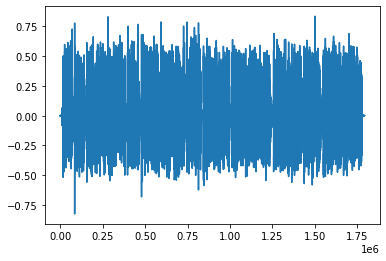

In [8]:
import matplotlib.pyplot as plt
print(y.shape)
plt.plot(y)
plt.show()

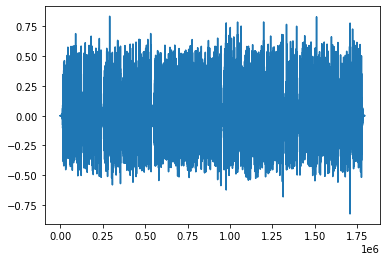

In [58]:
plt.plot(y_r)
plt.show()

In [60]:
s = librosa.core.stft(y, n_fft=800, hop_length=200, win_length=800)

In [62]:
s.shape

(401, 8961)

/home/chuhk/anaconda3/envs/nvp/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


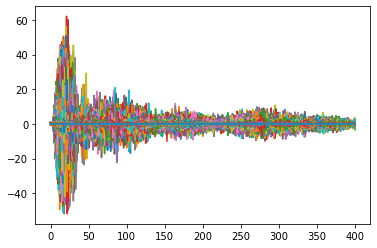

In [63]:
%matplotlib inline
plt.plot(s)
plt.show()

In [64]:
s_re = librosa.core.stft(y_r, n_fft=800, hop_length=200, win_length=800)

In [65]:
s_re.shape

(401, 8961)

/home/chuhk/anaconda3/envs/nvp/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


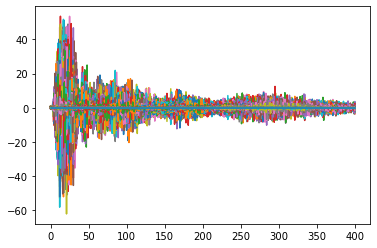

In [71]:
plt.plot(s_re)
plt.show()

array([[-1.4188093e-03+0.0000000e+00j,  4.3402514e-03+0.0000000e+00j,
         1.1196216e-02+0.0000000e+00j, ...,
        -1.0024074e-02+0.0000000e+00j, -9.7052557e-03+0.0000000e+00j,
        -1.7402901e-03+0.0000000e+00j],
       [ 4.0764939e-03-1.9003280e-19j, -2.5115313e-03+5.6553348e-03j,
        -6.8512028e-03+7.1512436e-04j, ...,
         6.4919982e-03-2.3551486e-03j,  7.0622279e-03+2.2923567e-03j,
         2.5320180e-05+5.5285161e-03j],
       [-1.8924236e-03-1.5756471e-18j,  1.1481170e-03-4.8063020e-03j,
         8.1350101e-04+2.9589736e-04j, ...,
        -1.6333661e-03-6.5797009e-04j, -1.1982477e-03+6.6263386e-04j,
         2.5442576e-03-3.7268572e-03j],
       ...,
       [ 8.3396561e-05+1.3181491e-18j, -5.8085188e-05-1.0316400e-03j,
        -2.7219614e-05+8.7996147e-04j, ...,
        -6.9574118e-05-9.9527184e-05j, -8.6903200e-04-6.8389723e-04j,
         6.0567737e-04+5.5460440e-04j],
       [-3.5927011e-04+2.6836977e-18j,  6.8023481e-04+7.6796586e-04j,
         7.8613102e-04

In [66]:
np.array_equal(s, np.flip(s_re))

False

In [67]:
ss=np.flip(s_re)

ValueError: only 1-dimensional arrays can be used

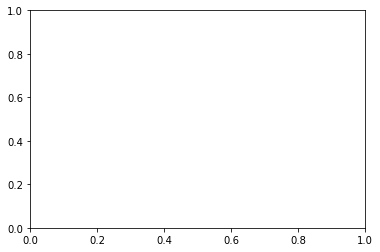

In [78]:
plt.plot(ss)
plt.show

In [70]:
s==ss

array([[ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       ...,
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False],
       [ True, False, False, ..., False, False, False]])

In [76]:
np.array_equal(s, s_re)

False

In [80]:
a_path = './wav2lip/org5_audio.wav'

are_path='./wav2lip/rev5_audio.wav'

yy, srr=librosa.load(a_path)

yyr, srrr=librosa.load(are_path)

In [81]:
yyrr=np.flip(yyr)

In [82]:
np.array_equal(yy,yyrr)

False

In [83]:
yy.shape

(110016,)

In [84]:
yyr.shape

(110016,)

In [85]:
yy

array([ 0.        ,  0.        ,  0.        , ..., -0.19059968,
       -0.13299823, -0.03669631], dtype=float32)

In [86]:
yyr

array([-0.00820639, -0.0810187 , -0.177187  , ...,  0.        ,
        0.        ,  0.        ], dtype=float32)